<a href="https://colab.research.google.com/github/hyanquiv/cnn-tests/blob/master/HAM10000_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"henryaronyanquivera","key":"eebb3d7d1e6824632f8a7f5160ef21ee"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip -d ham10000


Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: ham10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000/ham10000_images

In [4]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
# Cargar metadatos
df = pd.read_csv("ham10000/HAM10000_metadata.csv")

# Codificar etiquetas
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])

# Rutas de imágenes
image_dirs = ["ham10000/HAM10000_images_part_1", "ham10000/HAM10000_images_part_2"]

# Función para cargar imagen desde ambas carpetas
def load_image(image_id):
    for folder in image_dirs:
        image_path = os.path.join(folder, f"{image_id}.jpg")
        if os.path.exists(image_path):
            return np.array(Image.open(image_path).resize((64, 64)))
    raise FileNotFoundError(f"Imagen {image_id}.jpg no encontrada en las carpetas especificadas")

# Aplicar carga de imágenes
df['image'] = df['image_id'].apply(load_image)


In [6]:
X = np.stack(df['image'].values)
y = df['label'].values

# Normalizar imágenes
X = X / 255.0

# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [7]:
class HAMDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images.transpose(0, 3, 1, 2), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

batch_size = 32

train_loader = DataLoader(HAMDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(HAMDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(HAMDataset(X_test, y_test), batch_size=batch_size)


In [37]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out


In [40]:
class HAMNetResidual(nn.Module):
    def __init__(self, num_classes):
        super(HAMNetResidual, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64, downsample=True),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128, downsample=True),
            ResidualBlock(128, 128),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        # calcular tamaño de entrada del Linear dinámicamente
        self.flatten_dim = self._get_flatten_size()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def _get_flatten_size(self):
        # pasar una imagen dummy para obtener dimensiones
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 64, 64)
            x = self.initial(dummy)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.classifier(x)
        return x

model = HAMNetResidual(num_classes).to(device)


In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
train_losses, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validación
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Acc={val_acc:.4f}")


Epoch 1: Train Loss=0.5460, Val Acc=0.7836
Epoch 2: Train Loss=0.5149, Val Acc=0.7830
Epoch 3: Train Loss=0.4815, Val Acc=0.7876
Epoch 4: Train Loss=0.4759, Val Acc=0.7530
Epoch 5: Train Loss=0.4908, Val Acc=0.7690
Epoch 6: Train Loss=0.5147, Val Acc=0.7823
Epoch 7: Train Loss=0.4395, Val Acc=0.7743
Epoch 8: Train Loss=0.4114, Val Acc=0.7656
Epoch 9: Train Loss=0.3996, Val Acc=0.7783
Epoch 10: Train Loss=0.3935, Val Acc=0.7803
Epoch 11: Train Loss=0.4283, Val Acc=0.7730
Epoch 12: Train Loss=0.4531, Val Acc=0.7690
Epoch 13: Train Loss=0.3706, Val Acc=0.7650
Epoch 14: Train Loss=0.3969, Val Acc=0.7810
Epoch 15: Train Loss=0.3588, Val Acc=0.7783
Epoch 16: Train Loss=0.3050, Val Acc=0.7763
Epoch 17: Train Loss=0.3275, Val Acc=0.7783
Epoch 18: Train Loss=0.3414, Val Acc=0.7903
Epoch 19: Train Loss=0.2723, Val Acc=0.7743
Epoch 20: Train Loss=0.2677, Val Acc=0.7810
Epoch 21: Train Loss=0.2968, Val Acc=0.7570
Epoch 22: Train Loss=0.3537, Val Acc=0.7770
Epoch 23: Train Loss=0.2491, Val Acc=0.77

In [45]:
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(labels.numpy())

# Reporte
report = classification_report(all_true, all_preds, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report[["precision", "recall", "f1-score", "support"]])


              precision    recall  f1-score      support
akiec          0.391304  0.551020  0.457627    49.000000
bcc            0.571429  0.571429  0.571429    77.000000
bkl            0.421053  0.484848  0.450704   165.000000
df             0.428571  0.176471  0.250000    17.000000
mel            0.526786  0.353293  0.422939   167.000000
nv             0.875969  0.898608  0.887144  1006.000000
vasc           0.875000  0.636364  0.736842    22.000000
accuracy       0.752495  0.752495  0.752495     0.752495
macro avg      0.584302  0.524576  0.539526  1503.000000
weighted avg   0.750753  0.752495  0.748069  1503.000000


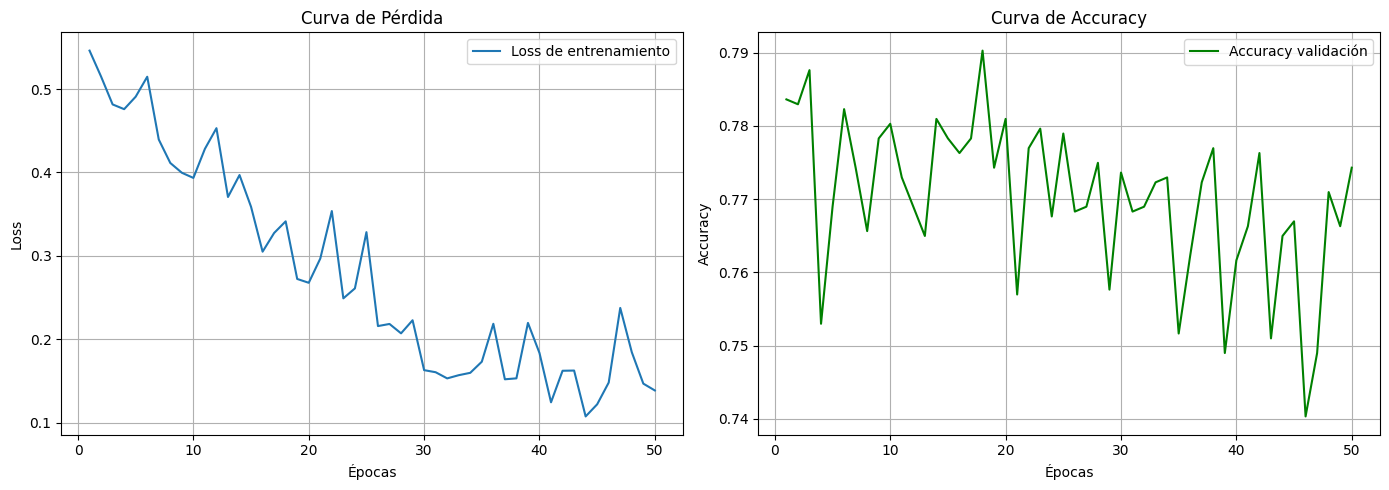

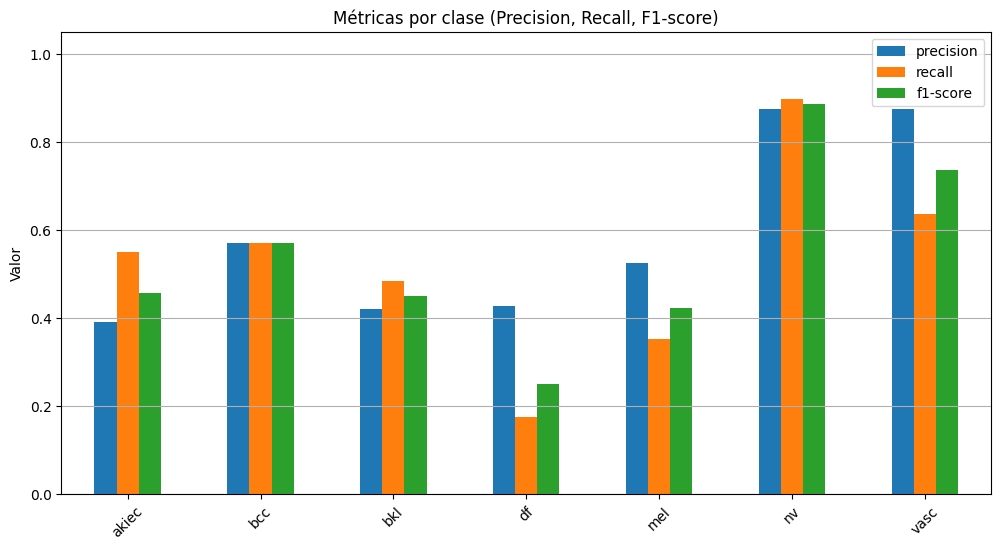

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Curvas de entrenamiento ---
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Curva de loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Loss de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Curva de Pérdida")
plt.grid(True)
plt.legend()

# Curva de accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label="Accuracy validación", color='green')
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Curva de Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# --- Métricas por clase ---
df_report.iloc[:-3][["precision", "recall", "f1-score"]].plot(kind='bar', figsize=(12, 6))
plt.title("Métricas por clase (Precision, Recall, F1-score)")
plt.ylabel("Valor")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()


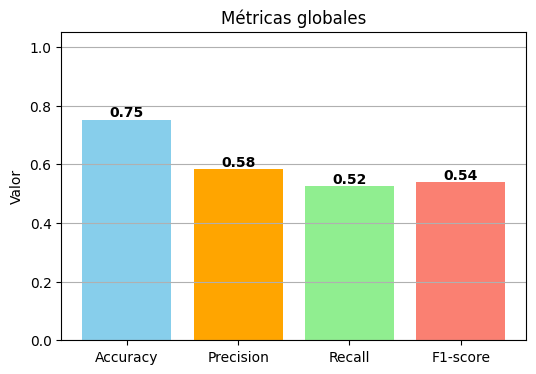

In [47]:
# Extraer métricas globales desde df_report
global_metrics = {
    "Accuracy": df_report.loc["accuracy", "precision"],  # 'accuracy' está como fila pero su valor aparece bajo "precision"
    "Precision": df_report.loc["macro avg", "precision"],
    "Recall": df_report.loc["macro avg", "recall"],
    "F1-score": df_report.loc["macro avg", "f1-score"]
}

# Graficar
plt.figure(figsize=(6, 4))
plt.bar(global_metrics.keys(), global_metrics.values(), color=['skyblue', 'orange', 'lightgreen', 'salmon'])
plt.ylim(0, 1.05)
plt.title("Métricas globales")
plt.ylabel("Valor")
plt.grid(axis='y')
for i, v in enumerate(global_metrics.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()